# Goal: Identifying Fraudulent Activities

To build a model that predicts whether a user has a high probability of using the site to
perform some illegal activity or not. 
Available data, 2 tables:

-"Fraud_Data" - information about each user's first transaction

-"IpAddress_to_Country" - mapping each numeric ip address to its country.
For each country, it gives a range. If the numeric ip address falls within
the range, then the ip address belongs to the corresponding country.

In [1]:
# Import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read in the data

fraud_data = pd.read_csv('fraud_data.csv')
ip_address = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
#Comparing the two tables

len(fraud_data) == len(ip_address)

False

###### Number of rows for the tables are different, check the difference

In [4]:
fraud_data.shape

(151112, 11)

In [5]:
ip_address.shape

(138846, 3)

In [6]:
len(fraud_data) == len(fraud_data.user_id) #all users are unique

True

######  Create a loop to look up the country from IP address range and insert a new column 'country' in the main dataset

In [7]:
# country = len(fraud_data) * [0]
# for ind, row in fraud_data.iterrows():
#     temp = ip_address[(ip_address['lower_bound_ip_address'] < row['ip_address']) & 
#            (ip_address['upper_bound_ip_address'] > row['ip_address'])]['country']
#     
#     if len(temp) == 1:
#         country[ind] = temp.values[0]
# fraud_data['country'] = country

In [8]:
# Create a new csv file with country to save time each time we run the kernel
#fraud_data.to_csv('full_data.csv')

In [9]:
# Read in the new table with country in a new dataframe called data
data = pd.read_csv('full_data.csv', parse_dates=['signup_time', 'purchase_time']) # parse the time columns

In [10]:
#Explore the dataset
data.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


######  Column Unnamed:0 to be removed from the dataframe being an incorrect index

In [11]:
data = data.drop('Unnamed: 0', 1)

In [12]:
#Check data structure ( types, missing values, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           151112 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


###### Sanity check of data

In [13]:
data.source.unique() # Ok only three sources

array(['SEO', 'Ads', 'Direct'], dtype=object)

In [14]:
data['country'].nunique()

182

In [15]:
data.sex.unique() # Ok only two sex

array(['M', 'F'], dtype=object)

In [16]:
data.browser.unique()

array(['Chrome', 'Opera', 'Safari', 'IE', 'FireFox'], dtype=object)

In [17]:
np.sort(data.age.unique()) # OK ages are reasonable

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 76], dtype=int64)

In [18]:
data['class'].unique() # OK only two classes: frauds and legit transactions

array([0, 1], dtype=int64)

###### Data appear all admissible. No further action requested as data cleaning

# FEATURES ENGINEERING

In [19]:
#Difference between signup time and purchase time
data['diff_time'] = (data['purchase_time'] - data['signup_time'])/np.timedelta64(1, 's')

In [20]:
# Different user id's using the same device
data['device_user_count'] = data.groupby('device_id')['user_id'].transform('count')

In [21]:
# Number of users' using a given ip address
data['ip_count'] = data.groupby('ip_address')['user_id'].transform('count')

In [22]:
# We might expect these last two features to be highly correlated, in case of fraudolent activities. Therefore, should we decide
#to use some linear model, one of the two should be dropped. On the contrary, using some kind of tree-based model, we will not have to 
#worry about it, because the model will take care of this problem, just ignoring one of the two variables.

In [23]:
# sign_up day of the week
data['signup_time_wd'] = data.signup_time.dt.dayofweek

In [24]:
# sign_up week of the year
data['signup_time_wy'] = data.signup_time.dt.weekofyear

In [25]:
# Explore modified data structure
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff_time,device_user_count,ip_count,signup_time_wd,signup_time_wy
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1,1,9
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1,6,23
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,492085.0,1,1,1,18
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1,1,30


In [26]:
np.sort(data['country']) # despite having no missing values, some countries are in fact missing and indentified with string'O'

array(['0', '0', '0', ..., 'Zimbabwe', 'Zimbabwe', 'Zimbabwe'], dtype=object)

###### Replace 0 in countries with 'Not Found'

In [27]:
data['country'] =data['country'].replace('0', 'Not Found') 

In [28]:
#Keep only the top 50 countries
#Replace everything else with 'Other'
top_50 = list(data.groupby('country')[['user_id']].count().sort_values('user_id', ascending = False).index)[0:50]
top_50 =top_50[0:1] + top_50[2:] # remove not found from the list

In [29]:
data['country_revised'] = np.where(data['country'].isin(top_50), data.country, 'other')

# Exploratory data analysis (EDA)

In [30]:
#determine the number of frauds in the dataset
fraud = data[data['class']==1]
valid = data[data['class']==0]
print('Fraud cases: {}'.format(len(fraud)))
print('Valid cases: {}'.format(len(valid)))

Fraud cases: 14151
Valid cases: 136961


In [31]:
print(data['class'].mean()*100)
print('% of frauds')


9.364577267192546
% of frauds


# Building a Machine Learning Model

In [32]:
#Response Variable
y = data['class']

In [33]:
#Feature matrix dropping all useless columns
X = data.drop(['user_id', 'signup_time','purchase_time','class', 'device_id', 'country', 'ip_address'], axis = 1)

In [34]:
# Explore feature matrix X

In [35]:
X.head()

,purchase_value,source,browser,sex,age,diff_time,device_user_count,ip_count,signup_time_wd,signup_time_wy,country_revised
0,34,SEO,Chrome,M,39,4506682.0,1,1,1,9,Japan
1,16,Ads,Chrome,F,53,17944.0,1,1,6,23,United States
2,15,SEO,Opera,M,53,1.0,12,12,3,1,United States
3,44,SEO,Safari,M,41,492085.0,1,1,1,18,other
4,39,Ads,Safari,M,45,4361461.0,1,1,1,30,United States


In [36]:
#Verify that feature matrix contains only numerical values and that no missing values are present
X.isnull().sum()

purchase_value       0
source               0
browser              0
sex                  0
age                  0
diff_time            0
device_user_count    0
ip_count             0
signup_time_wd       0
signup_time_wy       0
country_revised      0
dtype: int64

## Label Encoding of categorical variables

In [37]:
from sklearn.preprocessing import LabelEncoder #import the class
lb=LabelEncoder() #instatntiate the object
for feature in X.select_dtypes(include='O').columns.values: #loop inside feature matrix, encoding only categorical varaibles
    X[feature] = lb.fit_transform(X[feature])    

In [38]:
#Explore the feature matrix processed to be fed to a ML model
X.head()

,purchase_value,source,browser,sex,age,diff_time,device_user_count,ip_count,signup_time_wd,signup_time_wy,country_revised
0,34,2,0,1,39,4506682.0,1,1,1,9,25
1,16,0,0,0,53,17944.0,1,1,6,23,46
2,15,2,3,1,53,1.0,12,12,3,1,46
3,44,2,4,1,41,492085.0,1,1,1,18,49
4,39,0,4,1,45,4361461.0,1,1,1,30,46


# RANDOM FOREST

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33) # split the data in train and test sets

In [40]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators= 50, max_features=3, n_jobs=-1, oob_score=True, random_state=23 )
# parameters selection:
# n_estimators =50 to speed up process time and obtain acceptable results
# max_features set equal to 3 to reduce chance of overfitting
# n_jobs=-1 to exploit all cores
# oob_score = True to exploit internal cross validation tool of RF classifier
# random_state = 23 for reproducibility (MJ number)

In [41]:
# train the model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=True, random_state=23, verbose=0, warm_start=False)

In [42]:
acc = rf.score(X_train, y_train)
print('TRAINING ACCURACY: %.4f' % acc) 

TRAINING ACCURACY: 0.9994


###### training accuracy very high, no chance of underfitting, model no-biased

In [43]:
acc = rf.oob_score_
print('CROSS VALIDATION ACCURACY: %.4f' % acc) 

CROSS VALIDATION ACCURACY: 0.9560


###### cv accuracy close to training accuracy, no overfitting

In [44]:
acc = rf.score(X_test, y_test)
print('TEST ACCURACY: %.4f' % acc) 

TEST ACCURACY: 0.9557


###### Calculate, for comparison, null-accuracy, i.e. most predicted class percentage

In [45]:
Null_Accuracy = max(y_test.mean(), 1-y_test.mean()) #Binary Classification
print('Null Accuracy: %.4f' % Null_Accuracy) # Baseline for model evaluation

Null Accuracy: 0.9046


###### Accuracy model appear good, when compared with null accuracy. Nevertheless is necessasry to deepen results

In [46]:
# Store model predictions in a new object for further analysis
y_pred = rf.predict(X_test)

In [47]:
# import classes to perform confusion metric and classification report
from sklearn.metrics import confusion_matrix, classification_report

In [48]:
print (classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.98     45112
          1       0.99      0.54      0.70      4755

avg / total       0.96      0.96      0.95     49867



In [49]:
print (confusion_matrix(y_test, y_pred))

[[45075    37]
 [ 2172  2583]]


###### Recall is as low as 0.54. Therefore the model is able to catch only 54% of frauds : 2155 frauds (FN) are not detected.
###### Precision is 0.98. The model is correct in classifying frauds 98% of the times: only 51 (FP) transactions labelled as fraud are, in fact, legit operations. 
###### Recall's model is unsufficient. Must be rised, even at cost of losing in precision. A ROC analysis can help to improve threshold

# ROC analysis

In [50]:
# Calculate class predicted probability
prob_score = rf.predict_proba(X_test)
prob_score[:,1]

array([ 0.08,  0.06,  0.14, ...,  0.  ,  0.  ,  0.  ])

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
rf_roc_auc = roc_auc_score(y_test,prob_score[:,1])
print ("Random Forest AUC = %.2f" % rf_roc_auc)

Random Forest AUC = 0.85


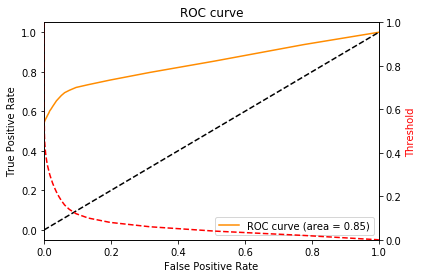

In [52]:
#Plotting the ROC curve
fpr,tpr,thresholds = roc_curve(y_test, prob_score[:,1])
plt.plot(fpr,tpr, color = 'darkorange', label='ROC curve (area = %0.2f)' % (rf_roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('roc_and_threshold.png')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]]);

In [53]:
# Optimize threshold to increase Recall
#ROC Analysis
i = np.arange(len(fpr))
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 
                    'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc['tf']-0).abs().argsort()[[0]]]

C:\Users\raffa\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,1-fpr,fpr,tf,thresholds,tpr
35,0.802669,0.197331,-0.04452,0.08,0.758149


In [54]:
# Rebuilding the random forest model reducing threshold to classify class 1 as low as 0.08

In [55]:
# Rebuilding the random forest model reducing threshold to classify class '1' as low as 0.08
prob = rf.predict_proba(X_test)[:,1]
prob[prob > 0.08] = 1
prob[prob <= 0.08] = 0

In [56]:
print (classification_report(y_test, prob))

             precision    recall  f1-score   support

          0       0.97      0.87      0.92     45112
          1       0.37      0.73      0.49      4755

avg / total       0.91      0.86      0.88     49867



In [57]:
print (confusion_matrix(y_test, prob))

[[39155  5957]
 [ 1261  3494]]


In [58]:
rf_roc_auc = roc_auc_score(y_test, prob)
print ("Random Forest AUC = %2.2f" % rf_roc_auc)

Random Forest AUC = 0.80


###### Recall went up to 73%. Lowering the threshold allowed the model to catch ca 3/4 of the frauds. Now only 1260 frauds go troughh undetected.
###### This, though, happened at the expenses of Precision which went down to 0.36. Now 6026 legit transactions are labelled as frauds.

# MODEL INSIGHTS

###### Utilize feature importances attributes automatically generated by the model to rank the importance of all features

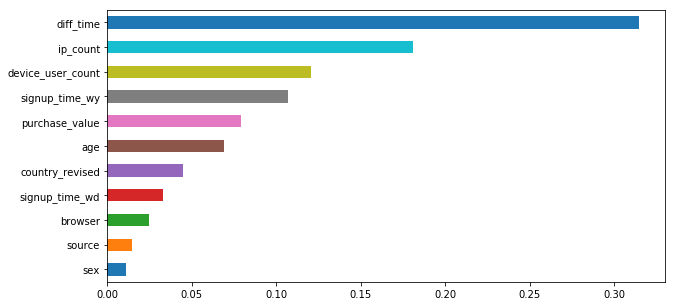

In [59]:
#Variables importance
rf.feature_importances_
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh', figsize=(10,5))

In [60]:
for v in sorted(zip(rf.feature_importances_, X),reverse=True):     
    print (v) 

(0.31428262953989722, 'diff_time')
(0.18110992023554678, 'ip_count')
(0.12073861056189605, 'device_user_count')
(0.10711453972310975, 'signup_time_wy')
(0.079325010217376757, 'purchase_value')
(0.068946908888901426, 'age')
(0.044966542430791706, 'country_revised')
(0.032868596113303179, 'signup_time_wd')
(0.024809231233367698, 'browser')
(0.01461436764943679, 'source')
(0.01122364340637263, 'sex')


###### The most sensible predictors of fraudent behavior are the engineered feature 'diff time' and the number of 'ip count'. 
###### we can use a decision tree model to check the first 3/4 depths level and gain some insights

# DECISION TREE FOR MAIN SPLITS

In [61]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(random_state=0, criterion = 'entropy', max_depth = 4)
tree.fit(X, y)
export_graphviz(tree, out_file='tree.dot', feature_names=X.columns, class_names=[' legits', 'frauds'],
               impurity=False, filled=True, node_ids= True, proportion=False)

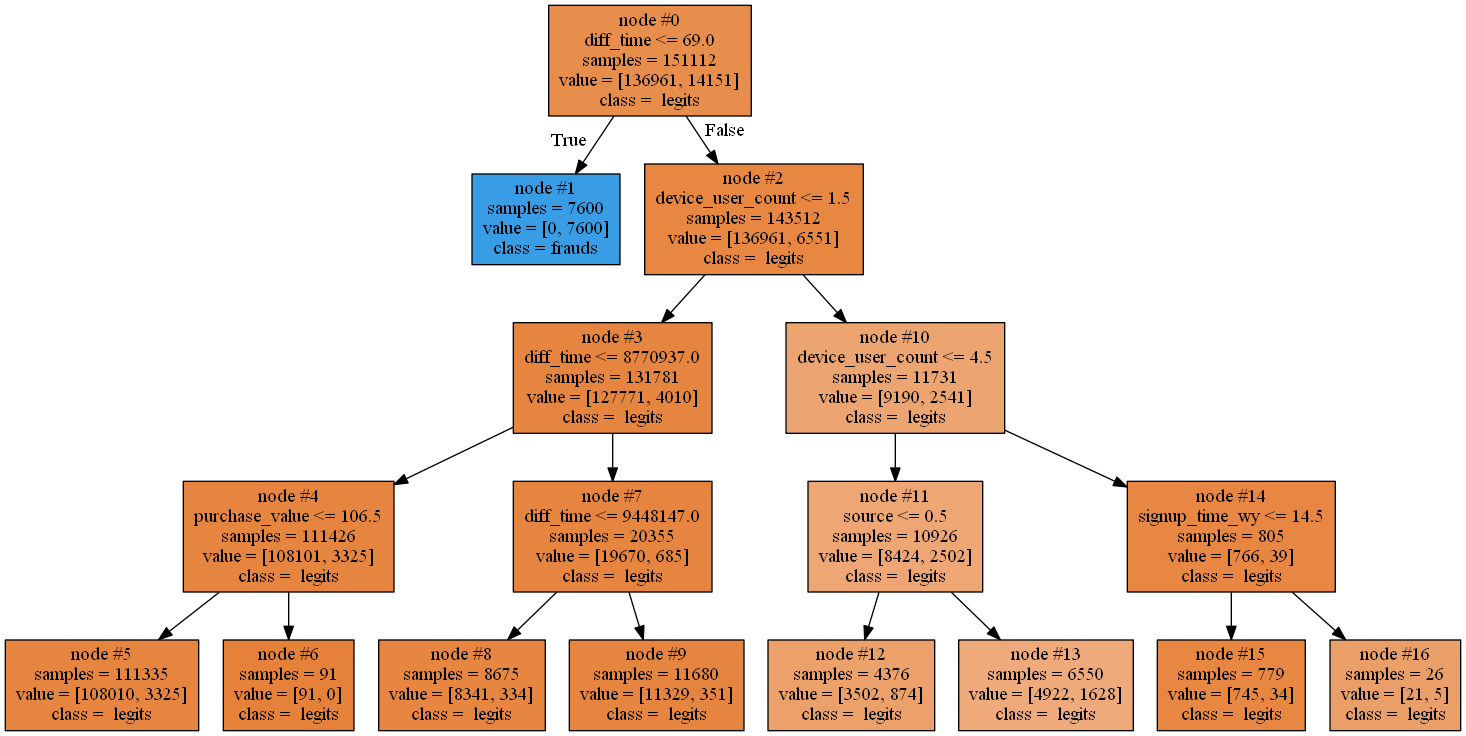

In [62]:
from IPython.display import Image
Image(filename='tree.png') 

In [63]:
# According to tree's splits, the most important variable is, by far, the difference time between sign up and first purchase.
# Whenever lesser than 70 seconds is an astonishing 100% fraud. No surprise, though, if matched with real life, considered that performing the
# first purchase should require some time to the user to get accustomed with the website. As high as half of the frauds lay inside this cluster.

# Among the remaining ones another consistent chunk of frauds is identified within those users, that, despite having only one IP and purchasing
# throug just a single device, within around three months, purchased something whose value is below the 106.5$.

# Numbers of device, Numbers of IP show a behaviour a bit unexpected. Most of the frauds performed by these categories are related to 
# users with 2-3-4 devices. We might have expected a very strong relation with higher numbers of devices.
# Among this bucket some influence seems to  be exerted by the source, with fraudsters landing on the site through Ads and Directs.


# ANOMALY DETECTION

###### Let's use AD approach to compare results

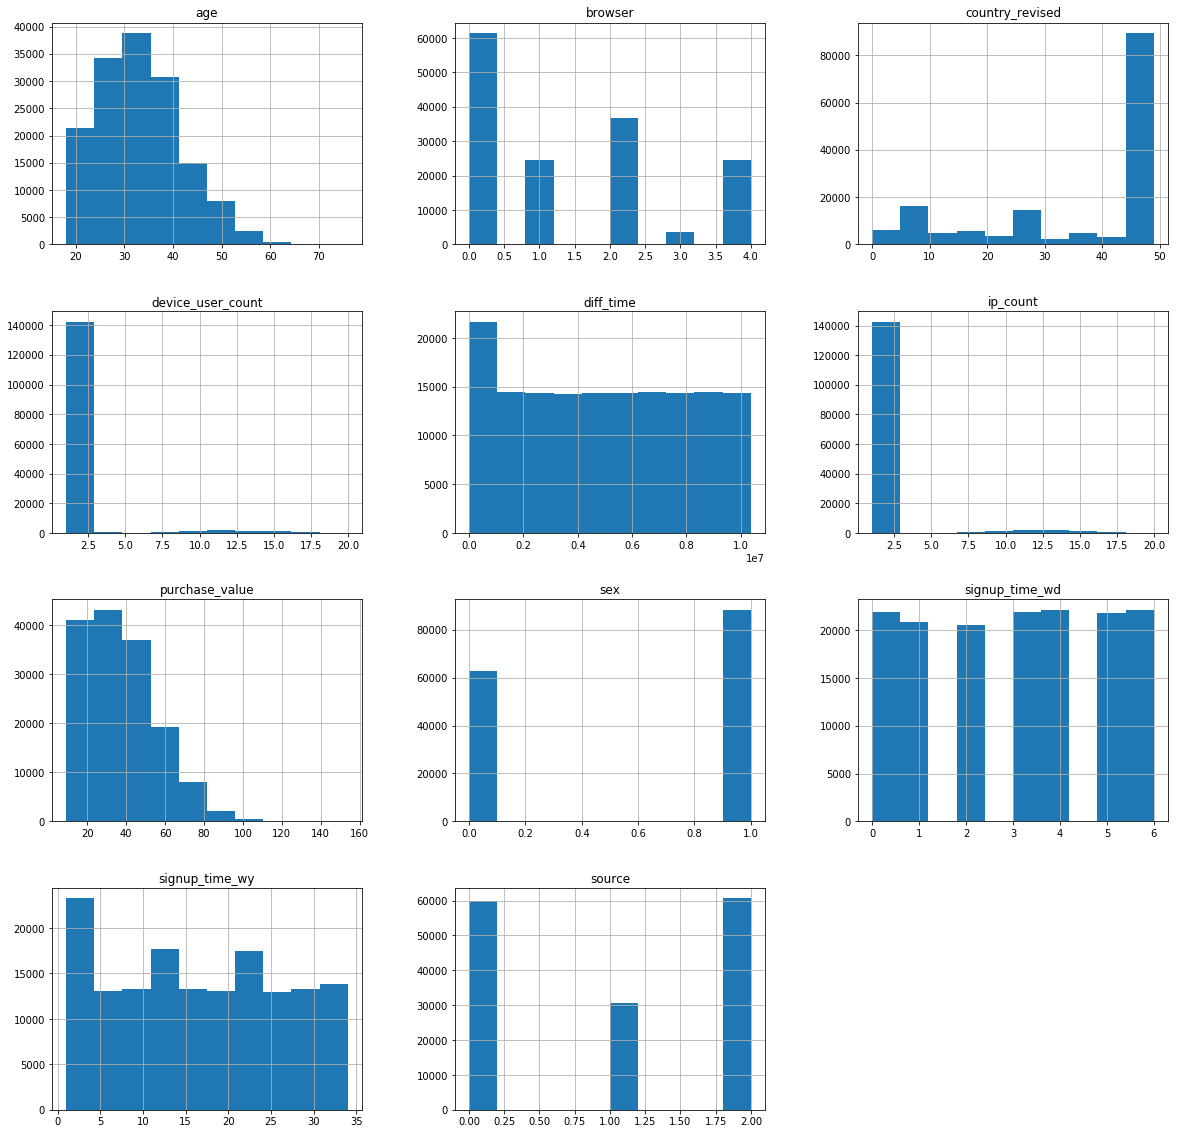

In [64]:
#plot histograms
X.hist(figsize=(20,20))
plt.show();

In [65]:
#determine the number of outliers in the dataset
outlier_fraction = len(fraud)/float((len(valid)))
print('Fraction of outlier: {}'.format(outlier_fraction))

Fraction of outlier: 0.10332138345952498


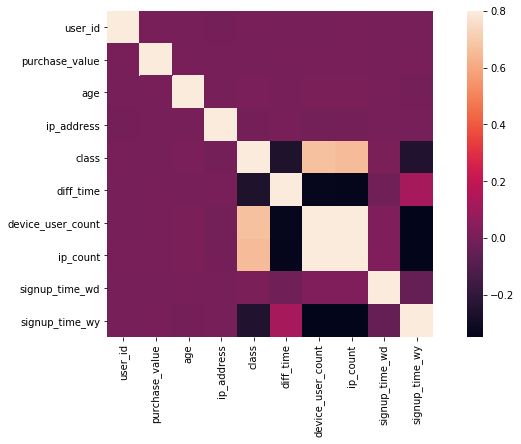

In [66]:
#correlation matrix, check the existence of strong correlation between variables
corrmat = data.corr()
fig = plt.figure(figsize=(12,6))
sns.heatmap(corrmat, square=True, vmax=0.8);

In [67]:
# Import anomaly detection common classifiers
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Import accuracy score metrics
from sklearn.metrics import accuracy_score

In [68]:
# define the outlier detection method
classifiers = {
    "Isolation forest": IsolationForest(max_samples=len(X),
                                       contamination= outlier_fraction,
                                       n_jobs=-1,
                                       random_state= 23),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20,
                                              contamination= outlier_fraction)
    
}

In [69]:
#fit the model
n_outliers = len(fraud)
for i, (clf_name, clf) in enumerate(classifiers.items()): # enumerate to loop through classifiers and extraxcting from dictionary
    
    #fix the data and tag  outliers
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
     
    # reshape the prediction values 0 for legit, 1 for fraud
    y_pred[y_pred==1] = 0
    y_pred[y_pred==-1] = 1
    n_errors = (y_pred !=y).sum()

    # run the classification matrix
    print(' Model {}: n_errors{}'.format(clf_name, n_errors) )
    print('Accuracy score:{}'.format(accuracy_score(y, y_pred)))
    print('Classification report:{}'.format( classification_report(y, y_pred)))
    
    # print the confusion matrix
    print('Confusion Matrix: ')
    print((confusion_matrix(y, y_pred)))
    
    # print a new line for  readibility
    print('\n')    

 Model Isolation forest: n_errors14390
Accuracy score:0.9047726189845942
Classification report:             precision    recall  f1-score   support

          0       0.95      0.94      0.95    136961
          1       0.49      0.54      0.52     14151

avg / total       0.91      0.90      0.91    151112

Confusion Matrix: 
[[129035   7926]
 [  6464   7687]]


 Model Local Outlier Factor: n_errors24336
Accuracy score:0.8389538885065382
Classification report:             precision    recall  f1-score   support

          0       0.92      0.91      0.91    136961
          1       0.17      0.19      0.18     14151

avg / total       0.85      0.84      0.84    151112

Confusion Matrix: 
[[124062  12899]
 [ 11437   2714]]




###### Anomaly detection models perform much worse than classical ML algorithms. Even Isolation Forest performances are worse than basic RF